# Import Dependencies

In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from datetime import date
from datetime import time
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [3]:
# Create Engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Using inspect to look at both tables
inspector = inspect(engine)

measure_columns = inspector.get_columns("measurement")
print("Measurement Table")
for column in measure_columns:
    print(column["name"], column["type"])

print("\n")

print("Station Table")
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"], column["type"])

Measurement Table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Station Table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Using datetime to find the dates 1 year ago
d = dt.date(2017, 8, 23)
print(d)

new_date = d - timedelta(days=365)
print(new_date)

2017-08-23
2016-08-23


In [10]:
# Querying for previous 12 months of data
precip_12 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').\
    order_by(desc(Measurement.date)).all()

# Using Pandas to create a DataFrame
df_precip_12 = pd.DataFrame(precip_12)

# Cleaning data
df_precip_12 = df_precip_12.fillna(value=0)
df_precip_12.set_index('date', drop=True, inplace=True)
df_precip_12 = df_precip_12.rename(columns={"prcp":"precipitation"})

# Precipitation DataFrame with date as index
df_precip_12.head()

,precipitation
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


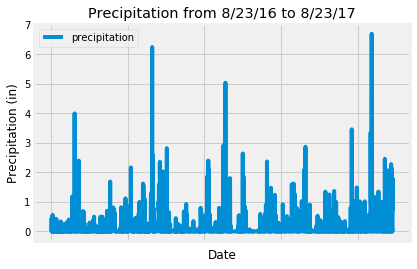

In [11]:
# Plotting the data
df_precip_12.plot()
plt.title("Precipitation from 8/23/16 to 8/23/17")
plt.legend(loc=2)
plt.xlabel("Date")
plt.ylabel("Precipitation (in)");

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip_12.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [13]:
# How many stations are available in this dataset?
session.query(Station.id).count()

9

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for each in active:
    print(each)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Creating Lists
station_list = []
counts_list = []
for each in active:
    station_list.append(each[0])
    counts_list.append(each[1])

# Creating DataFrame
active_data = {"Station":station_list, "Counts":counts_list}
active_df = pd.DataFrame(active_data)
active_df

,Station,Counts
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Highest Temp
highest = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281')
for each in highest:
    print(each)

# Lowest Temp
lowest = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281')
for each in lowest:
    print(each)

# Average Temp
average = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281')
for each in average:
    print(each)

(85.0,)
(54.0,)
(71.66378066378067,)


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Querying for data
temps_12 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').\
    order_by(desc(Measurement.date)).all()
temps_12_df = pd.DataFrame(temps_12)
temps_12_df.head()

,date,tobs
0,2017-08-18,79.0
1,2017-08-17,76.0
2,2017-08-16,76.0
3,2017-08-15,77.0
4,2017-08-14,77.0


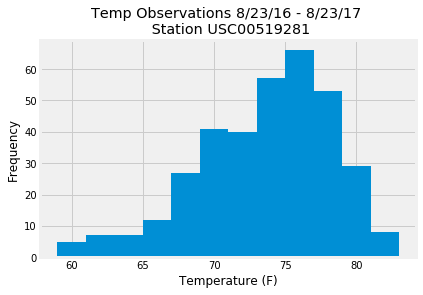

In [18]:
# Plotting the results
plt.hist(temps_12_df["tobs"], bins=12)
plt.title("Temp Observations 8/23/16 - 8/23/17 \n Station USC00519281")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

## Calculating Temps 6/1/17-6/7/17

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-06-01', '2017-06-07'))

[(74.0, 77.84444444444445, 81.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
t_data = calc_temps('2016-06-01', '2017-06-01')
print(t_data)

[(58.0, 74.38633377135348, 87.0)]


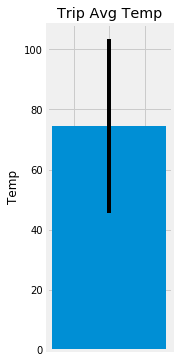

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2, 6))
plt.bar(x=0, height=t_data[0][1], yerr=t_data[0][2] - t_data[0][0])
plt.title("Trip Avg Temp")
plt.ylabel("Temp")
plt.tick_params(axis='x', labelbottom=False)
plt.show()